# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
from cycler import cycler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

# Data structure

In [3]:
str_fun_fine = {'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}, 'label' : 'Fine grid N=384'}
str_fun_coarse = {'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}, 'label' : 'Coarse grid N=128'}
str_fun_coarse_interp = {'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}, 'label' : 'Coarse grid N=128 interp'}
str_fun_coarse_add = {'X' : {'direction': 'X'}, 'Y' : {'direction': 'Y'}, 'Z' : {'direction': 'Z'}, 'label' : 'Coarse grid N=128 m5'}

# Read files

## Reading routines

In [4]:
def read_table_file(common_folder, folder_in, file_type, quantity, iterations, direction, name) :
    iterations_list = list(range(iterations[0], iterations[1], iterations[2]))
    nb_of_iterations = len(iterations_list)
    for i in iterations_list :
        file = common_folder + folder_in + file_type + "_for_" + quantity + "_at_" + "%06d" % i + "_dir_" + direction + name + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = 1.0/nb_of_iterations
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (i == iterations_list[0]) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    numpy_file_table = np.array(accumulated_data)
    return numpy_file_table

In [5]:
def read_table_spec_file(common_folder, folder_in, file_type, quantity, iterations) :
    iterations_list = list(range(iterations[0], iterations[1], iterations[2]))
    nb_of_iterations = len(iterations_list)
    for i in iterations_list :
        file = common_folder + folder_in + file_type +  "_" + quantity + "%06d" % i + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = 1.0/nb_of_iterations
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (i == iterations_list[0]) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    numpy_file_table = np.array(accumulated_data)
    return numpy_file_table

In [6]:
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_spec_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
    Exx = spec_table[:,3]
    Eyy = spec_table[:,4]
    Ezz = spec_table[:,5]
#    return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

## Path and parameters of the simulation

In [7]:
common_folder = "/home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/"
eps_scaling = 4/3
D0 = 0.001
max_iter = 5
iterations = [1, max_iter, 1]

## Read velocity structure functions

In [8]:
#for direction in {'X', 'Y', 'Z'} :
for direction in {'X'} :
    table = read_table_file(common_folder, "m0_interp/", "structFonc02thOrder", "velo", iterations, direction, "")
    str_fun_fine[direction].update({'r' : table[:,0], 'XX' : table[:,1], 'YY' : table[:,2], 'ZZ' : table[:,3]})
    
    table = read_table_file(common_folder, "m0_interp/", "structFonc02thOrder", "velo", iterations, direction, "_vel_interp")
    str_fun_coarse_interp[direction].update({'r' : table[:,0], 'XX' : table[:,1], 'YY' : table[:,2], 'ZZ' : table[:,3]})
    
    table = read_table_file(common_folder, "m0_interp/no_interp/", "structFonc02thOrder", "velo", iterations, direction, "")
    str_fun_coarse[direction].update({'r' : table[:,0], 'XX' : table[:,1], 'YY' : table[:,2], 'ZZ' : table[:,3]})
    
    table = read_table_file(common_folder, "m5_add/", "structFonc02thOrder", "velo", iterations, direction, "")
    str_fun_coarse_add[direction].update({'r' : table[:,0], 'XX' : table[:,1], 'YY' : table[:,2], 'ZZ' : table[:,3]})

reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000001_dir_X.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000002_dir_X.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000003_dir_X.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000004_dir_X.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000001_dir_X_vel_interp.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/structFonc02thOrder_for_velo_at_000002_dir_X_vel_interp.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N

## Read velocity spectrum

In [9]:
[k_fine, nb_of_modes_fine, Ek_fine] = read_spec_file(common_folder, "m0_interp/", "vel", "lin", 2)

reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/vel_spec_lin_ite=000002.table


In [10]:
[k_coarse, nb_of_modes_coarse, Ek_coarse] = read_spec_file(common_folder, "m0_interp/no_interp/", "vel", "lin", 50)

reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/no_interp/vel_spec_lin_ite=000050.table


In [11]:
table = read_table_spec_file(common_folder, "m0_interp/", "spec", "ScalarS1", iterations)
k_coarse_interp = table[:,0]
Ek_coarse_interp = table[:,1]

reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/spec_ScalarS1000001.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/spec_ScalarS1000002.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/spec_ScalarS1000003.table
reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m0_interp/spec_ScalarS1000004.table


In [12]:
[k_coarse_m5, nb_of_modes_coarse_m5, Ek_coarse_m5] = read_spec_file(common_folder, "m5_add/", "vel", "lin", 50)

reading file: /home/gorbunov8a/CODE/random_advection_test/velocity_fields_test/e43/N128/m5_add/vel_spec_lin_ite=000050.table


# Plot options

In [13]:
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

# Spectrum

<IPython.core.display.Javascript object>


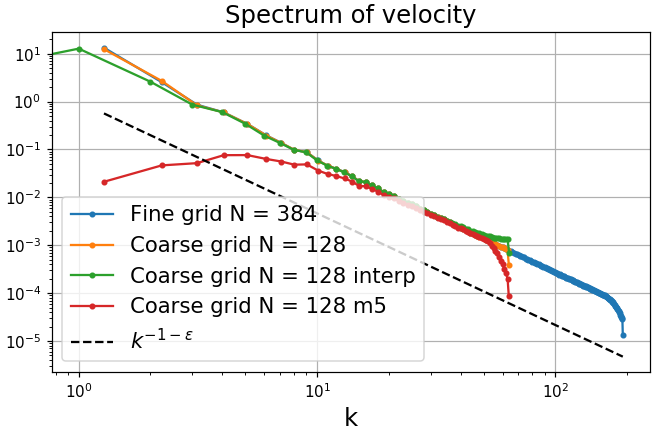

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

#spherical_coef = 4.0*np.pi*k**2/nb_of_modes

ax.plot(k_fine, Ek_fine, '.-', label='Fine grid N = 384')
ax.plot(k_coarse, Ek_coarse, '.-', label='Coarse grid N = 128')
ax.plot(k_coarse_interp, Ek_coarse_interp, '.-', label='Coarse grid N = 128 interp')
ax.plot(k_coarse_m5, Ek_coarse_m5, '.-', label='Coarse grid N = 128 m5')
ax.plot(k_fine, k_fine**(-1.0-eps_scaling), 'k--', label=r'$k^{-1-\epsilon}$')
ax.set(xscale='log', yscale='log', xlabel='k', title='Spectrum of velocity'); ax.grid()
ax.legend(loc='best')

plt.show()

# Longitudinal velocity structure function

<IPython.core.display.Javascript object>


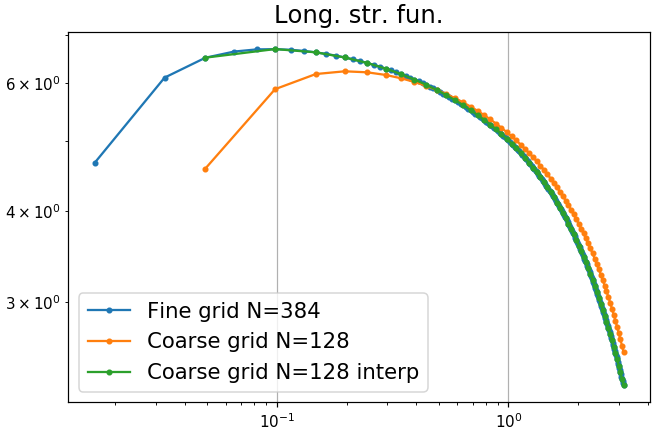

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

for data in [str_fun_fine, str_fun_coarse, str_fun_coarse_interp] :
    ax.plot(data['X']['r'], data['X']['XX']*(data['X']['r']**(-eps_scaling)), '.-', label=data['label'])
ax.set(xscale='log', yscale='log', title='Long. str. fun.'); ax.grid()
ax.legend(loc='best')

plt.show()

<IPython.core.display.Javascript object>


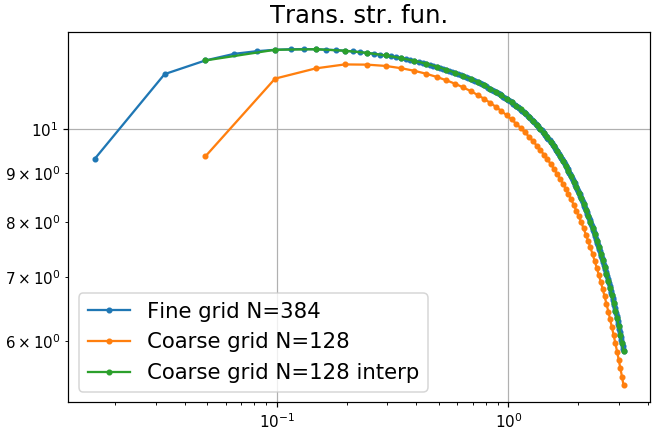

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,4))

for data in [str_fun_fine, str_fun_coarse, str_fun_coarse_interp] :
    ax.plot(data['X']['r'], data['X']['YY']*(data['X']['r']**(-eps_scaling)), '.-', label=data['label'])
ax.set(xscale='log', yscale='log', title='Trans. str. fun.'); ax.grid()
ax.legend(loc='best')

plt.show()